# Problem Statement 

Our client, Telco, is a home phone and internet service provider with over 7,000 clients based in South East Asia. They have provided a data set with information on their current customers and customers who have switched providers. Using this data, they would like to understand which factors are driving customer churn, strengthen their customer retention strategies, and proactively reduce their churn rate. 

# Data Overview

The data set consists of 7,043 records with twenty customer attributes divided into two categories: demographic data and  information related to customer's wireless accounts. The demographic features includes the customer's gender, whether they have a partner, dependents, and are 65 years or older. The features related to their account information include how long the customer has been with Telco, their monthly and total charges, the contract each customer carries (month-to-month, one year, or two years), and the type of phone, internet, and TV services they have. Our response variable for this study is `Churn`, a binary indicator that represents whether or not the customer left within the last month. 

There were 11 customers with missing `TotalCharges`. Since it is a fairly small amount, these observations will be removed prior to beginning the analysis, leaving 7,032 customers in the data set. In addition, several of the `Yes`/`No` categorical variables contained an additional group indicating that the customer had no phone or internet service. These were recoded and combined with the value `No`.

In [1]:
suppressMessages(library(tidyverse))
suppressMessages(library(caret))
suppressMessages(library(reshape2))
suppressMessages(library(broom))
suppressMessages(library(randomForest))
suppressMessages(library(performanceEstimation))
suppressMessages(library(regclass))
suppressMessages(library(GGally))
suppressMessages(library(pROC))
suppressMessages(library(plotROC))
suppressMessages(library(cowplot))
suppressMessages(library(grid))
suppressMessages(library(gridExtra))
suppressMessages(library(formattable))
suppressMessages(library(scales))
theme_set(theme_minimal())
options(warn=-1)

telco <- read_csv("../input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv", show_col_types = FALSE) %>%
  mutate_if(is.character, factor)

telco$SeniorCitizen <- as.factor(telco$SeniorCitizen)

telco <- telco %>% 
  select(-customerID) %>% 
  mutate_at(7, ~as.factor(case_when(. == "No phone service" ~ "No",
                                    . == "No" ~ "No", TRUE ~ "Yes"))) %>% 
  mutate_at(8, ~as.factor(case_when(. == "Fiber optic" ~ "FiberOptic",
                                    . == "DSL" ~ "DSL", TRUE ~ "No"))) %>% 
  mutate_at(c(9:14), ~as.factor(case_when(. == "No internet service" ~ "No", 
                                          . == "No" ~ "No", TRUE ~ "Yes"))) %>%
  mutate_at(17, ~as.factor(case_when(. == "Bank transfer (automatic)" ~ "BankTransferAuto", 
                                     . == "Credit card (automatic)" ~ "CreditCardAuto", 
                                     . == "Electronic check" ~ "ECheck", TRUE ~ "MailedCheck"))) %>% 
  na.omit()

telco %>% 
  group_by(gender) %>% 
  rename("Gender" = gender) %>% 
  summarise("Number of Observations" = n(),
            "Average Tenure, in months" = round(mean(tenure), 0),
            "Monthly Charges" = round(mean(MonthlyCharges), 2))

Gender,Number of Observations,"Average Tenure, in months",Monthly Charges
<fct>,<int>,<dbl>,<dbl>
Female,3483,32,65.22
Male,3549,33,64.39


Based on the overall gender composition of our sample, there is an approximately equal number of men and women in the data set. Their average bill is around $65/month and the tenure of both groups is a little over 2 and a half years, with men staying slightly longer than women on average.

# Exploratory Data Analysis
## What is a customer's average tenure with Telco and what are their average charges?

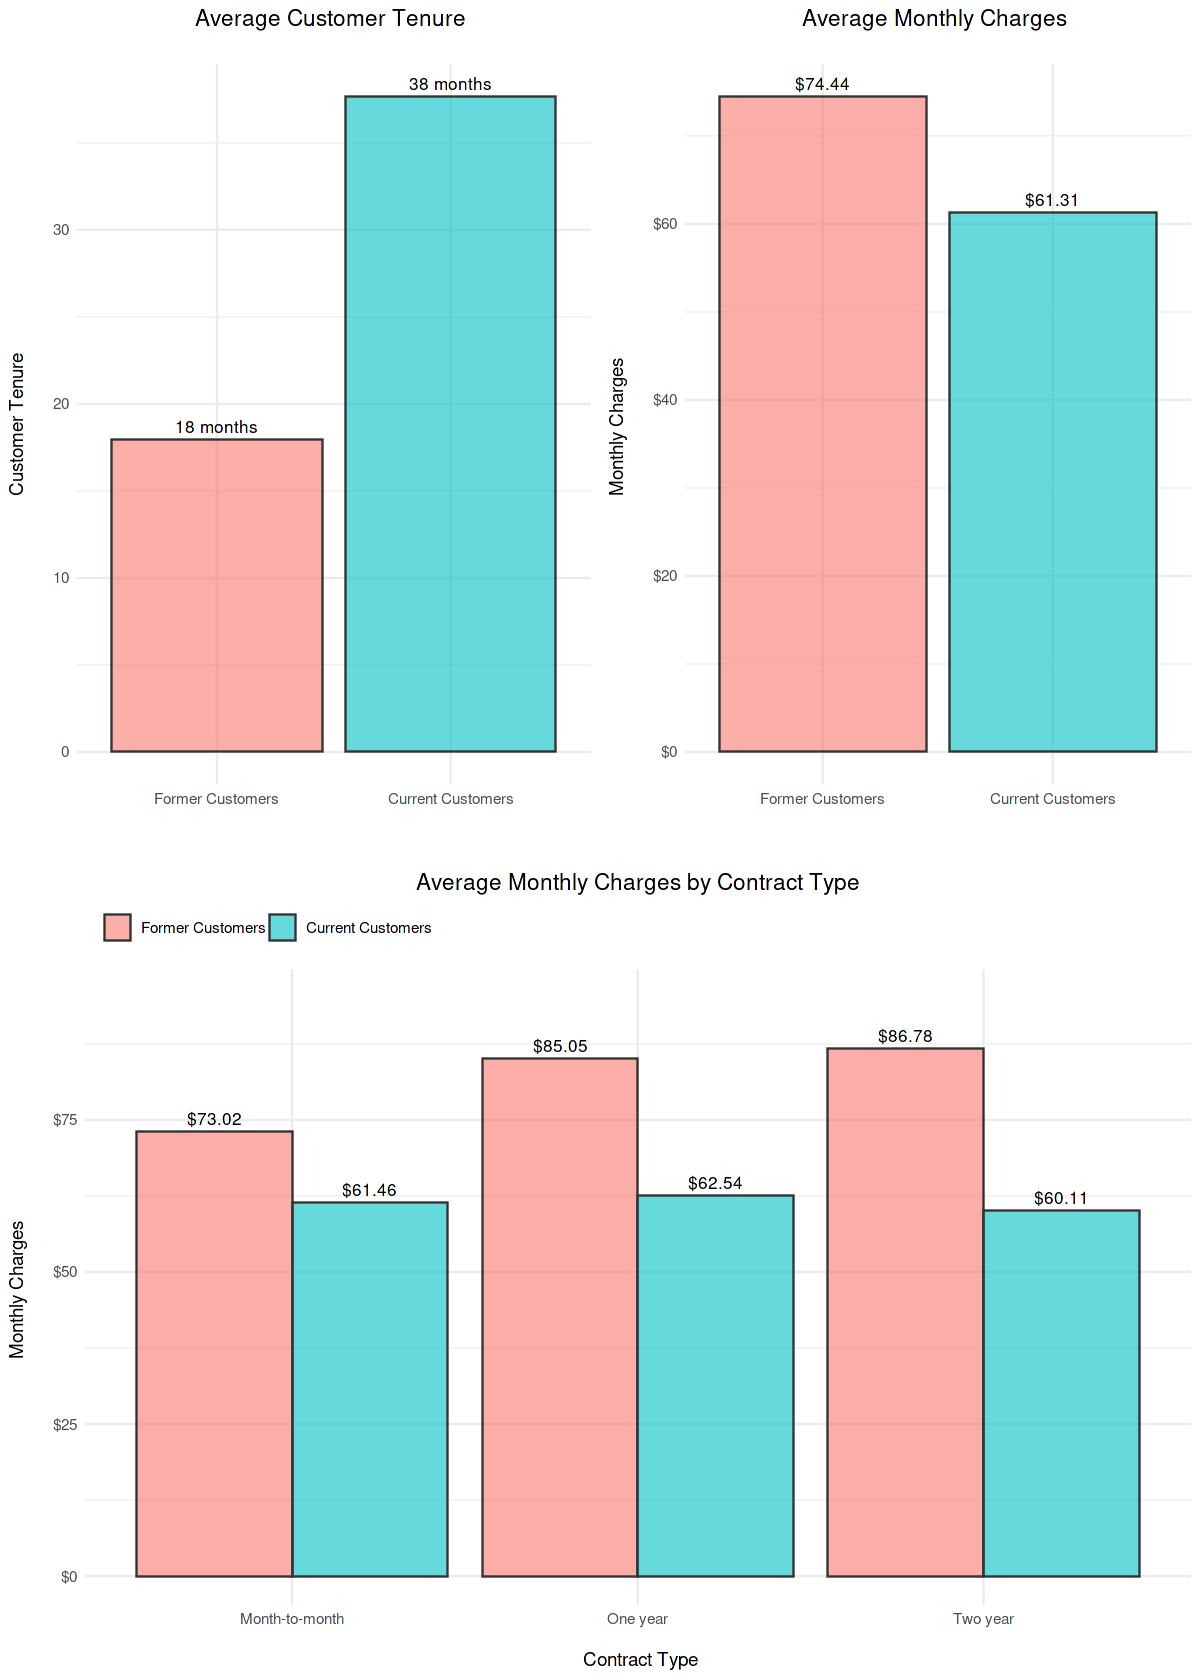

In [2]:
t2 <- telco %>% 
  mutate(Churn2 = as.factor(ifelse(Churn == "Yes", "Former Customers", "Current Customers"))) 

g1 <- ggplot(t2, aes(x = fct_rev(Churn2), y = tenure, fill = fct_rev(Churn2))) +
  geom_bar(stat = "summary", fun = "mean", alpha = 0.6, color = "grey20", show.legend = F) +
  stat_summary(aes(label = paste(round(..y.., 0), "months")), fun = mean, 
               geom = "text", size = 3.5, vjust = -0.5) +
  labs(title = "Average Customer Tenure \n", x = "", y = "Customer Tenure\n") +
  theme(plot.title = element_text(hjust = 0.5))

g2 <- ggplot(t2, aes(x = fct_rev(Churn2), y = MonthlyCharges, fill = fct_rev(Churn2))) +
  geom_bar(stat = "summary", fun = "mean", alpha = 0.6, color = "grey20", show.legend = F) +
  stat_summary(aes(label = dollar(..y..)), fun = mean, 
               geom = "text", size = 3.5, vjust = -0.5) +
  scale_y_continuous(labels = dollar_format()) +
  labs(title = "Average Monthly Charges \n", x = "", y = "Monthly Charges \n") +
  theme(plot.title = element_text(hjust = 0.5))

g3 <- ggplot(t2, aes(x = Contract, y = MonthlyCharges, fill = fct_rev(Churn2))) +
  geom_bar(position = "dodge", stat = "summary", fun = "mean", alpha = 0.6, color = "grey20") +
  stat_summary(aes(label = dollar(..y..)), fun = mean, 
               geom = "text", size = 3.5, vjust = -0.5,
               position = position_dodge(width = 0.9)) +
  coord_cartesian(ylim = c(0, 95)) +
  scale_y_continuous(labels = dollar_format()) +
  labs(title = "\nAverage Monthly Charges by Contract Type", x = "\n Contract Type", 
       y = "Monthly Charges \n", fill = "") +
  theme(plot.title = element_text(hjust = 0.5), legend.position = "top", legend.justification = "left")

options(repr.plot.width=10, repr.plot.height=14)
grid.arrange(g1, g2, g3, ncol = 2, nrow = 2, layout_matrix = rbind(c(1,2), c(3,3)))

The graphs above show the average tenure of Telco’s current and former customers, and their monthly charges. Telco's current customers have been with the company for just over three years, while those who have left stayed with the company for about 18 months. Additionally, customers who left had higher monthly charges on average by about $13. This holds true across each contract type. 

## What type of account services do customers have?

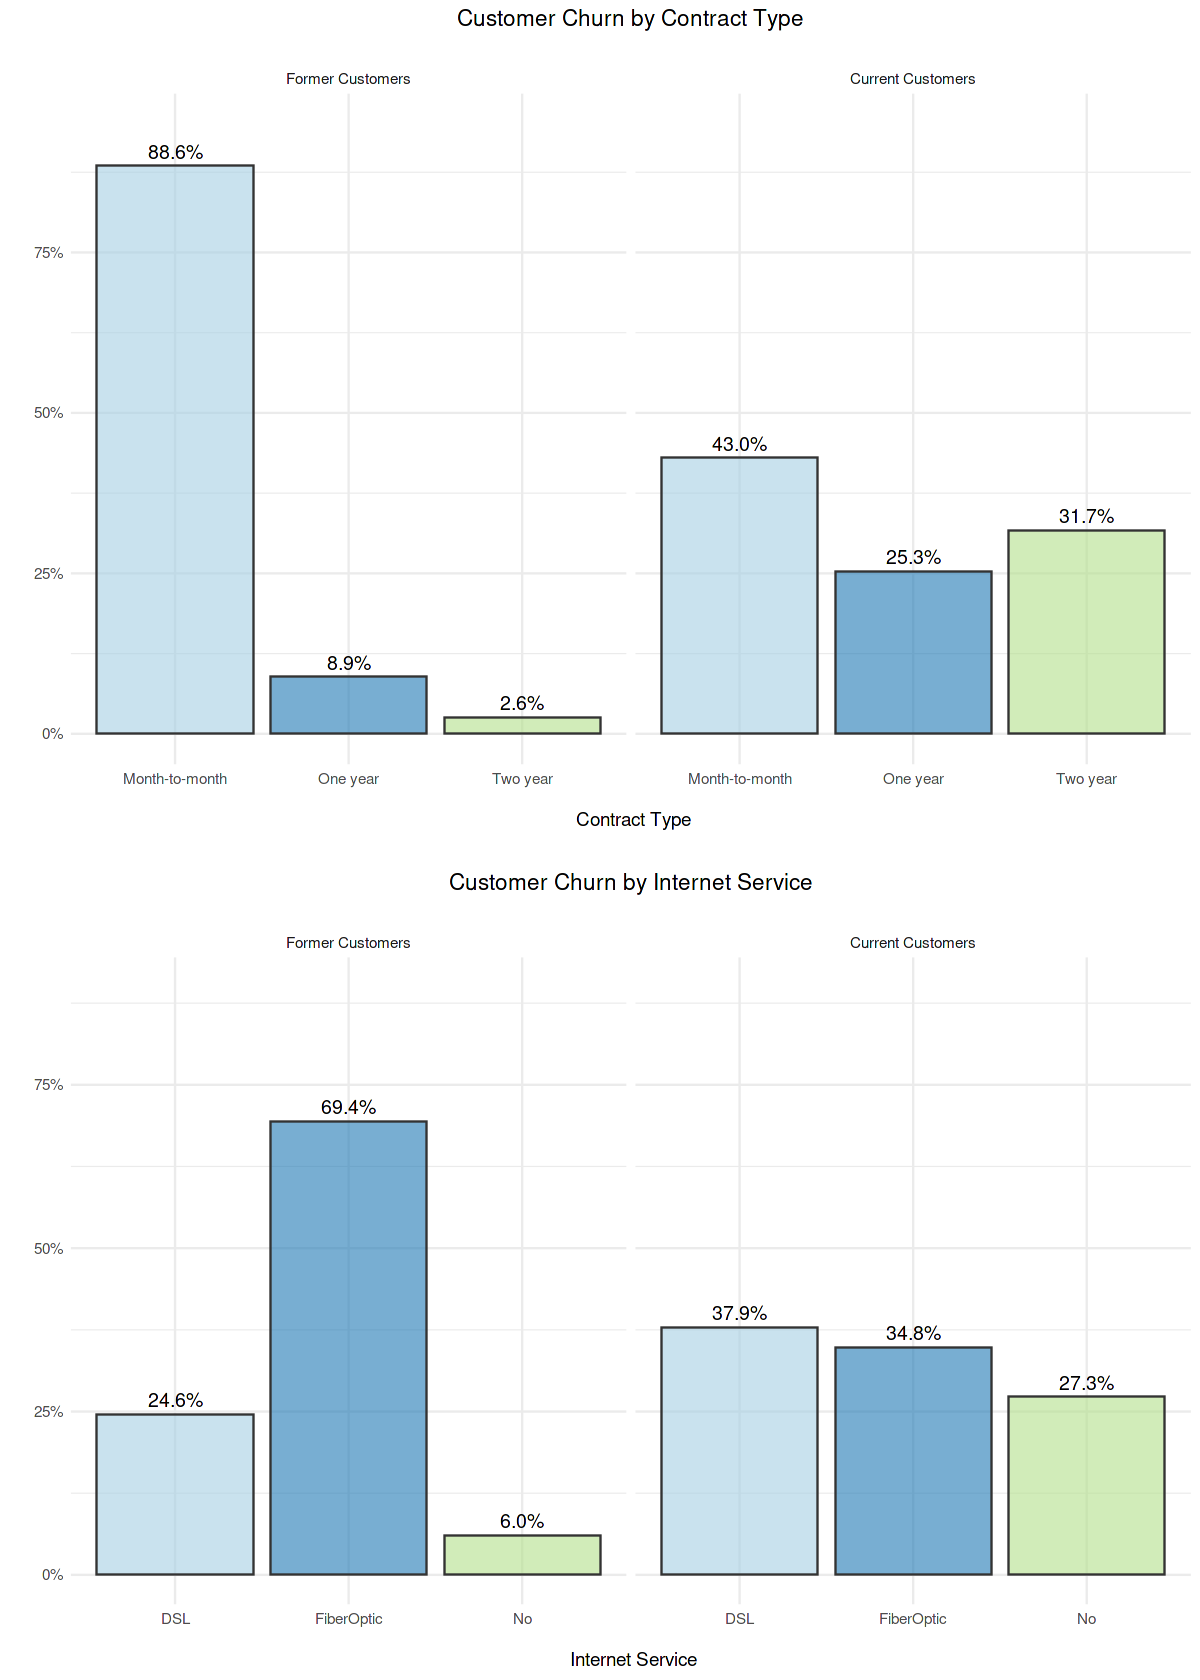

In [3]:
g1 <- ggplot(t2, aes(x = Contract, group = fct_rev(Churn2))) + 
  geom_bar(aes(y = ..prop.., fill = factor(..x..)), stat = "count",
           alpha = 0.6, color = "grey20", show.legend = F) +
  geom_text(aes(label = percent(..prop..), y = ..prop.. ), 
            size = 4, stat = "count", vjust = -0.5) +
  facet_grid(~fct_rev(Churn2)) +
  scale_y_continuous(labels = percent_format()) +
  coord_cartesian(ylim = c(0, .95)) +
  scale_fill_brewer(palette = "Paired") +
  labs(title = "Customer Churn by Contract Type\n", x = "\n Contract Type", y = "") +
  theme(plot.title = element_text(hjust = 0.5))

g2 <- ggplot(t2, aes(x = InternetService, group = fct_rev(Churn2))) + 
  geom_bar(aes(y = ..prop.., fill = factor(..x..)), stat = "count",
           alpha = 0.6, color = "grey20", show.legend = F) +
  geom_text(aes(label = percent(..prop..), y = ..prop.. ), 
            size = 4, stat = "count", vjust = -0.5) +
  facet_grid(~fct_rev(Churn2)) +
  scale_y_continuous(labels = percent_format()) +
  coord_cartesian(ylim = c(0, .9)) +
  scale_fill_brewer(palette = "Paired") +
  labs(title = "\n Customer Churn by Internet Service \n", x = "\n Internet Service", y = "") +
  theme(plot.title = element_text(hjust = 0.5))

grid.arrange(g1, g2, ncol = 1)

Nearly 89% of customers who left Telco were on month-to-month contracts, with a much smaller proportion in one or two-year contracts. Of custmors who left, a little over 69% had Fiber Optic internet. This could be an indicator of potential dissatisfaction with the service and should be further reviewed by the company since over a third of their customers currently have this type of internet.

## Customer Attrition Demographics

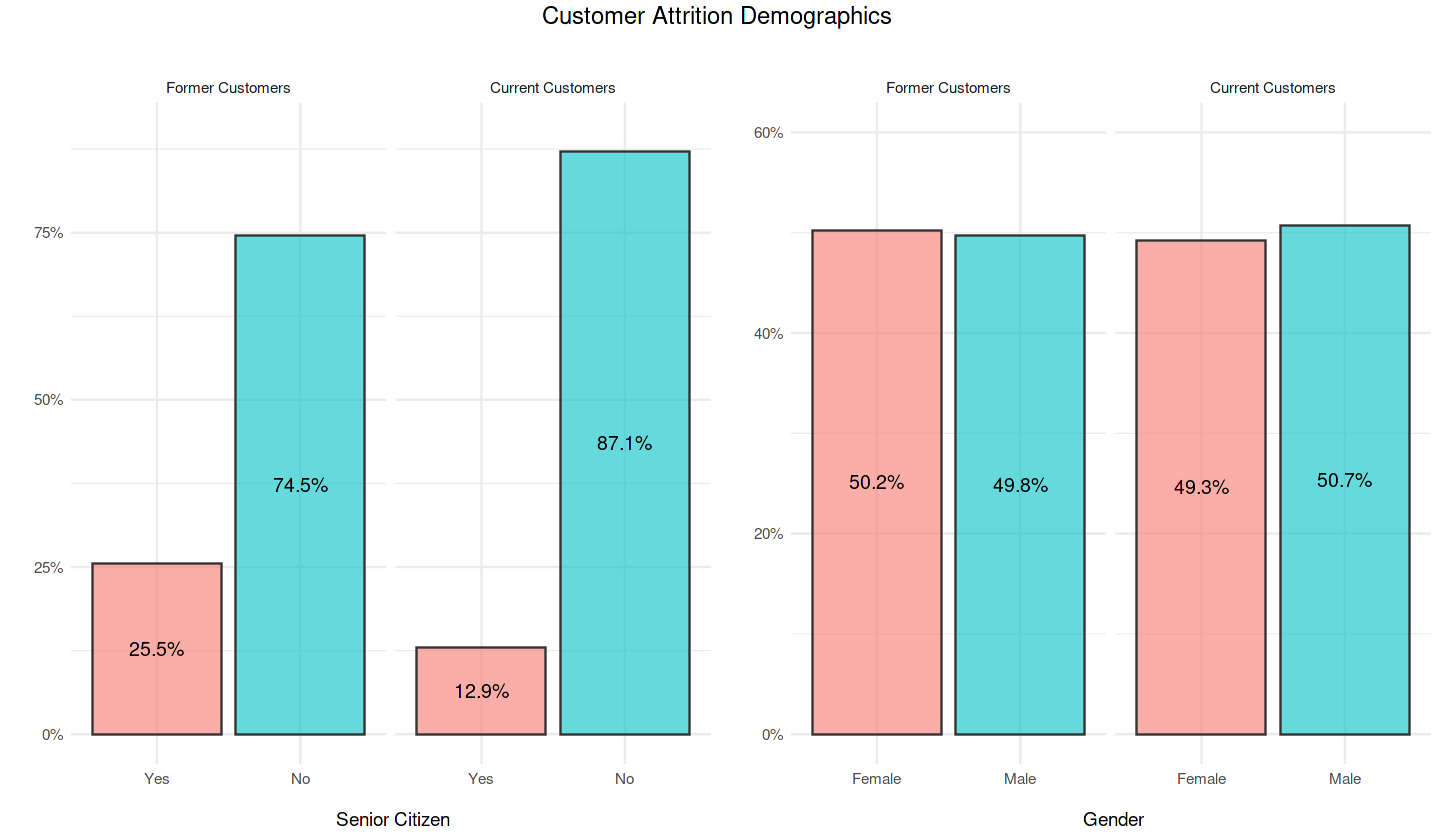

In [4]:
g1 <- ggplot(t2, aes(x = fct_rev(ifelse(SeniorCitizen==1, "Yes", "No")), group = Churn2)) + 
  geom_bar(aes(y = ..prop.., fill = factor(..x..)), stat = "count",
           alpha = 0.6, color = "grey20", show.legend = F) +
  geom_text(aes(label = percent(..prop.., accuracy = 0.1), y = ..prop..), 
            size = 4, stat = "count", position = position_stack(vjust = 0.5)) +
  facet_grid(~fct_rev(Churn2)) +
  scale_y_continuous(labels = percent_format(accuracy = 1)) +
  coord_cartesian(ylim = c(0, .9)) +
  labs(x = "\n Senior Citizen", y = "")

g2 <- ggplot(t2, aes(x = gender, group = Churn2)) + 
  geom_bar(aes(y = ..prop.., fill = factor(..x..)), stat = "count",
           alpha = 0.6, color = "grey20", show.legend = F) +
  geom_text(aes(label = percent(..prop.., accuracy = 0.1), y = ..prop..), 
            size = 4, stat = "count", position = position_stack(vjust = 0.5)) +
  facet_grid(~fct_rev(Churn2)) +
  scale_y_continuous(labels = percent_format(accuracy = 1)) +
  coord_cartesian(ylim = c(0, .6)) +
  labs(x = "\n Gender", y = "")

options(repr.plot.width=12, repr.plot.height=7)
grid.arrange(g1, g2, nrow = 1, top = textGrob("Customer Attrition Demographics \n",
                                              gp = gpar(fontsize = 14)))

Based on the demographic attributes of Telco's customers, about a quarter of those who left were senior citizens, and just under 13% of their current customers are 65 years or older. The distribution of customers by gender is very similar, approximately an equal proportion of men and women left within the last month.

## Distributions and Correlations

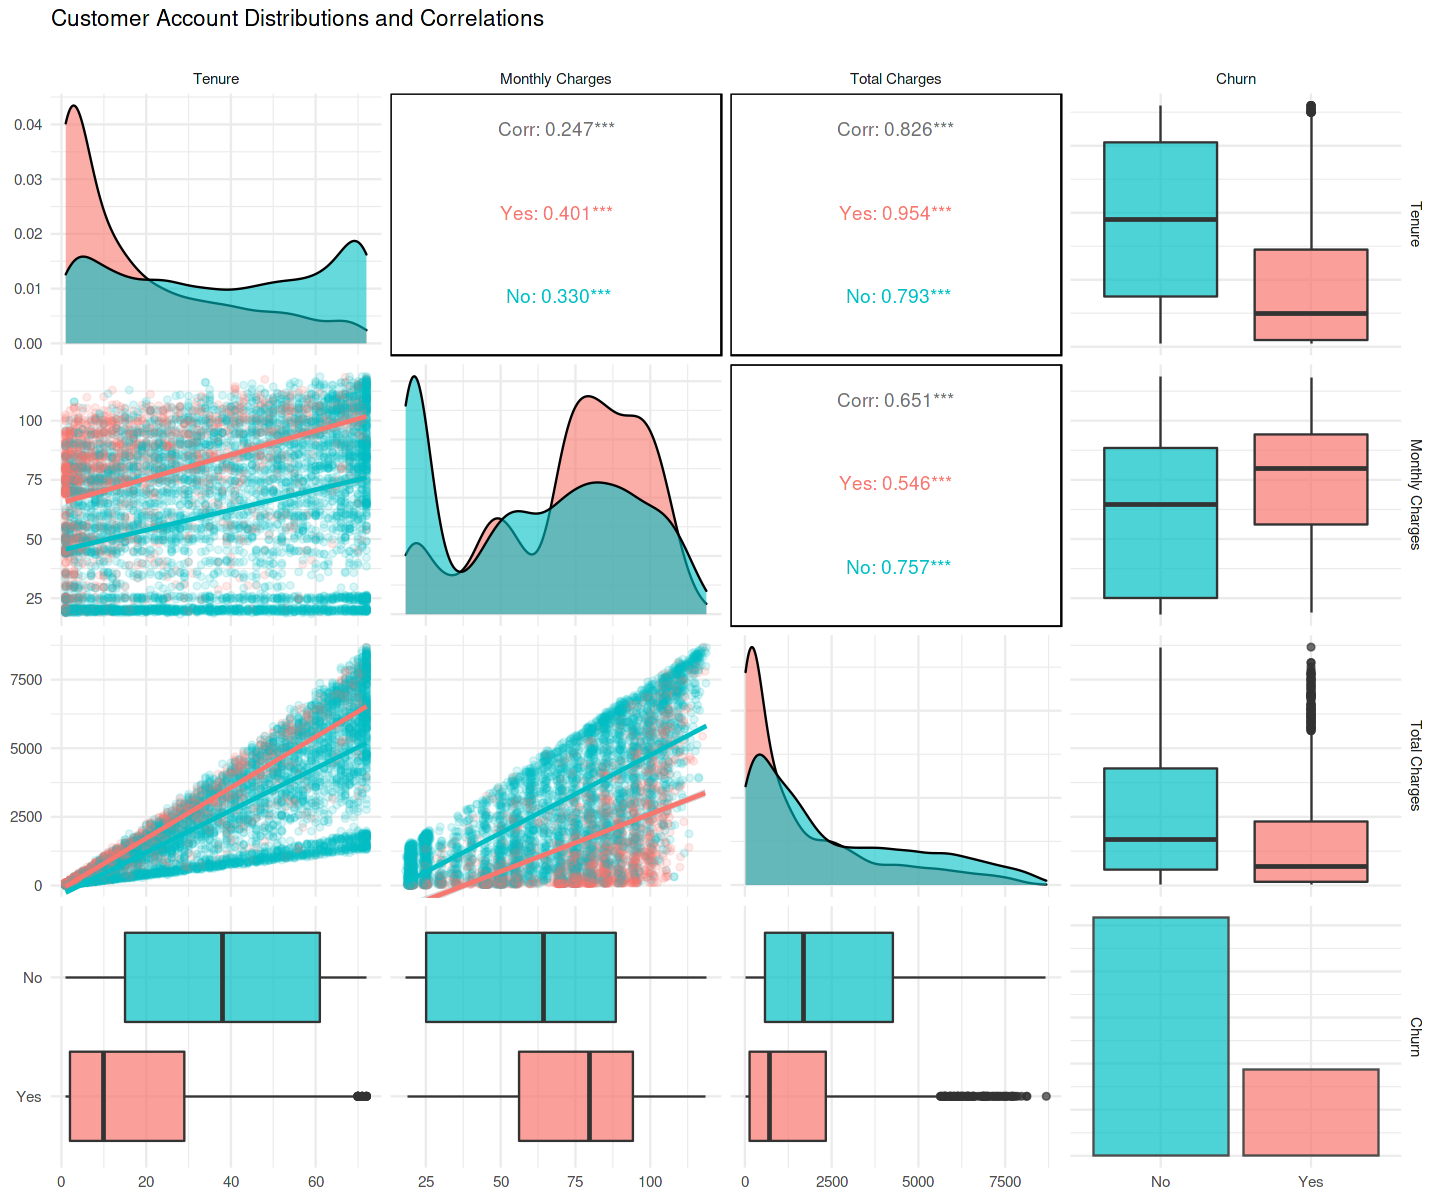

In [5]:
options(repr.plot.width=12, repr.plot.height=10)
telco %>% 
  select(tenure, MonthlyCharges, TotalCharges, Churn) %>%
  ggpairs(aes(color = fct_rev(Churn)), title = "Customer Account Distributions and Correlations \n",
          columnLabels = c("Tenure", "Monthly Charges", "Total Charges", "Churn"),
          upper = list(combo = wrap("box_no_facet", alpha = 0.7)),
          diag = list(continuous = wrap("densityDiag", alpha = 0.6), 
                      discrete = wrap("barDiag", alpha = 0.7, color = "grey30")),
          lower = list(combo = wrap("box_no_facet", alpha = 0.7), continuous = wrap("smooth", alpha = 0.15))) 

The correlations between our numeric variables show that `TotalCharges` is strongly correlated with customer tenure, especially among customers who left (`Churn = Yes`), with a correlation of more than 0.95. There is also a slightly positive relationship between `MonthlyCharges` and `Tenure` of 0.25 and it is significant. The histogram of `MonthlyCharges` has a very unique, multimodal shape, while the distribution of customer tenure is relatively uniform among current customers but is skewed to the right in customers who left.

# Data Preprocessing

Our target variable, `Churn`, is quite imbalanced with a little over 26% (1,869 customers) leaving the company within the past month. Since class imbalance can negatively affect the precision and recall accuracy of statistical models, I will use a **s**ynthetic **m**inority **o**ver-sampling **te**chnique known as **[smote](https://rdrr.io/cran/performanceEstimation/man/smote.html)** to create a more evenly distributed training set. 

The `smote` algorithm artificially generates new instances of the minority class using the nearest neighbors of these cases and under-samples the majority class to create a more balanced data set. After applying `smote`, our training set now consists of an equal proportion of current and former customers.

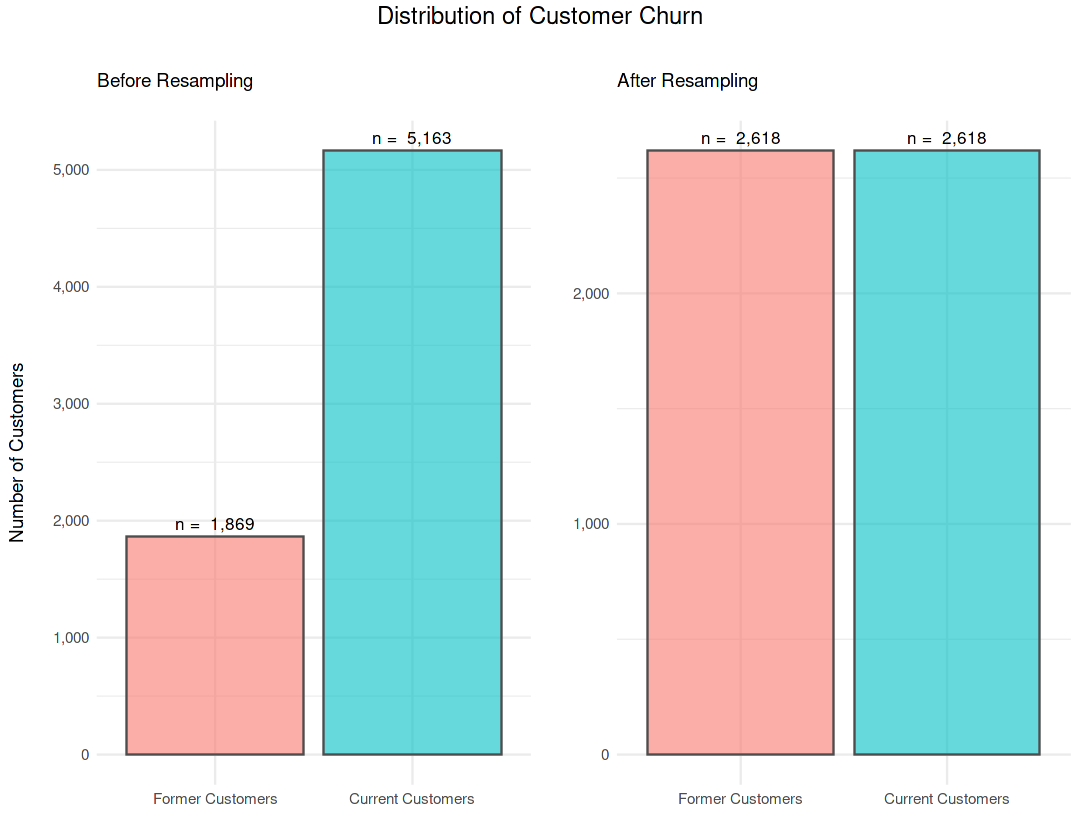

In [6]:
telco <- telco %>% 
  mutate_at(15, ~as.factor(case_when(. == "One year" ~ "OneYear", 
                                     . == "Two year" ~ "TwoYear", 
                                     TRUE ~ "Month-to-month"))) 

set.seed(1)
ind <- createDataPartition(telco$Churn, p = 0.7, list = F)
telco.train <- telco[ind,]
telco.test <- telco[-ind,]
train.resamp <- smote(Churn ~ ., data = data.frame(telco.train), perc.over = 1, perc.under = 2)

g1 <- ggplot(t2, aes(x = fct_rev(Churn2), fill = fct_rev(Churn2))) +
  geom_bar(alpha = 0.6, color = "grey30", show.legend = F) + 
  geom_text(stat = "count", size = 3.5, 
            aes(label = paste("n = ", formatC(..count.., big.mark = ","))), vjust = -0.5) +
  scale_y_continuous(labels = comma_format()) +
  labs(subtitle = "Before Resampling\n", x = "", y = "Number of Customers\n")

g2 <- ggplot(train.resamp, aes(x = fct_rev(ifelse(Churn == "Yes", "Former Customers", "Current Customers")), 
                               fill = fct_rev(Churn))) +
  geom_bar(alpha = 0.6, color = "grey30", show.legend = F) + 
  geom_text(stat = "count", size = 3.5, 
            aes(label = paste("n = ", formatC(..count.., big.mark = ","))), vjust = -0.5) +
  scale_y_continuous(labels = comma_format()) +
  labs(subtitle = "After Resampling\n", x = "", y = "")

options(repr.plot.width=9, repr.plot.height=7)
grid.arrange(g1, g2, nrow = 1, top = textGrob("Distribution of Customer Churn\n",
                                              gp = gpar(fontsize = 14)))

# Feature Selection

To identify which features should be included in the models, I will use a two-step process. First, I will check the chi-squared tests of independence between the categorical features and include only variables that have a statistically significant association to our response, `Churn`. Then, I will use the random forest algorithm to identify the most important predictors of customer churn. 

# Chi-Squared Tests

The Chi-Squared Test of Independence evaluates the association between two categorical variables. The null hypothesis for this test is that there is no relationship between our response variable and the categorical feature, and the alternative hypothesis is that that there is a relationship. Looking at the results of the tests, `Gender` and `PhoneService` have very small chi-squared statistics and p-values that are greater than the significance threshold, $a$, of 0.05, indicating they are independent of our target variable. The rest of the categorical features do have a statistically significant association to customer churn.

In [7]:
cat.var <- telco[,sapply(telco, is.factor)]
chi <- lapply(cat.var[,-17], function(x) chisq.test(cat.var[,17], x))
do.call(rbind, lapply(chi, tidy)) %>%
  arrange(p.value) %>%
  mutate_at(c(1,2), funs(round(., 3)))

,statistic,p.value,parameter,method
,<dbl>,<dbl>,<int>,<chr>
Contract,1179.546,0.000,2,Pearson's Chi-squared test
InternetService,728.696,0.000,2,Pearson's Chi-squared test
PaymentMethod,645.430,0.000,3,Pearson's Chi-squared test
PaperlessBilling,256.875,0.000,1,Pearson's Chi-squared test with Yates' continuity correction
OnlineSecurity,205.416,0.000,1,Pearson's Chi-squared test with Yates' continuity correction
TechSupport,189.967,0.000,1,Pearson's Chi-squared test with Yates' continuity correction
Dependents,186.322,0.000,1,Pearson's Chi-squared test with Yates' continuity correction
SeniorCitizen,158.441,0.000,1,Pearson's Chi-squared test with Yates' continuity correction
Partner,157.503,0.000,1,Pearson's Chi-squared test with Yates' continuity correction


## Variable Importance

The random forest algorithm uses two measures in calculating variable importance, mean decrease in Gini and mean decrease in accuracy. The [mean decrease in Gini](https://www.rdocumentation.org/packages/randomForest/versions/4.6-14/topics/importance) is the total decrease in node impurities from splitting on the variable measured by the Gini index, averaged over all trees in the model. The [mean decrease in accuracy](https://www.rdocumentation.org/packages/randomForest/versions/4.6-14/topics/importance), also called permutation importance, measures the average decrease in prediction accuracy when the values of each variable are randomly permuted in the out-of-bag samples.

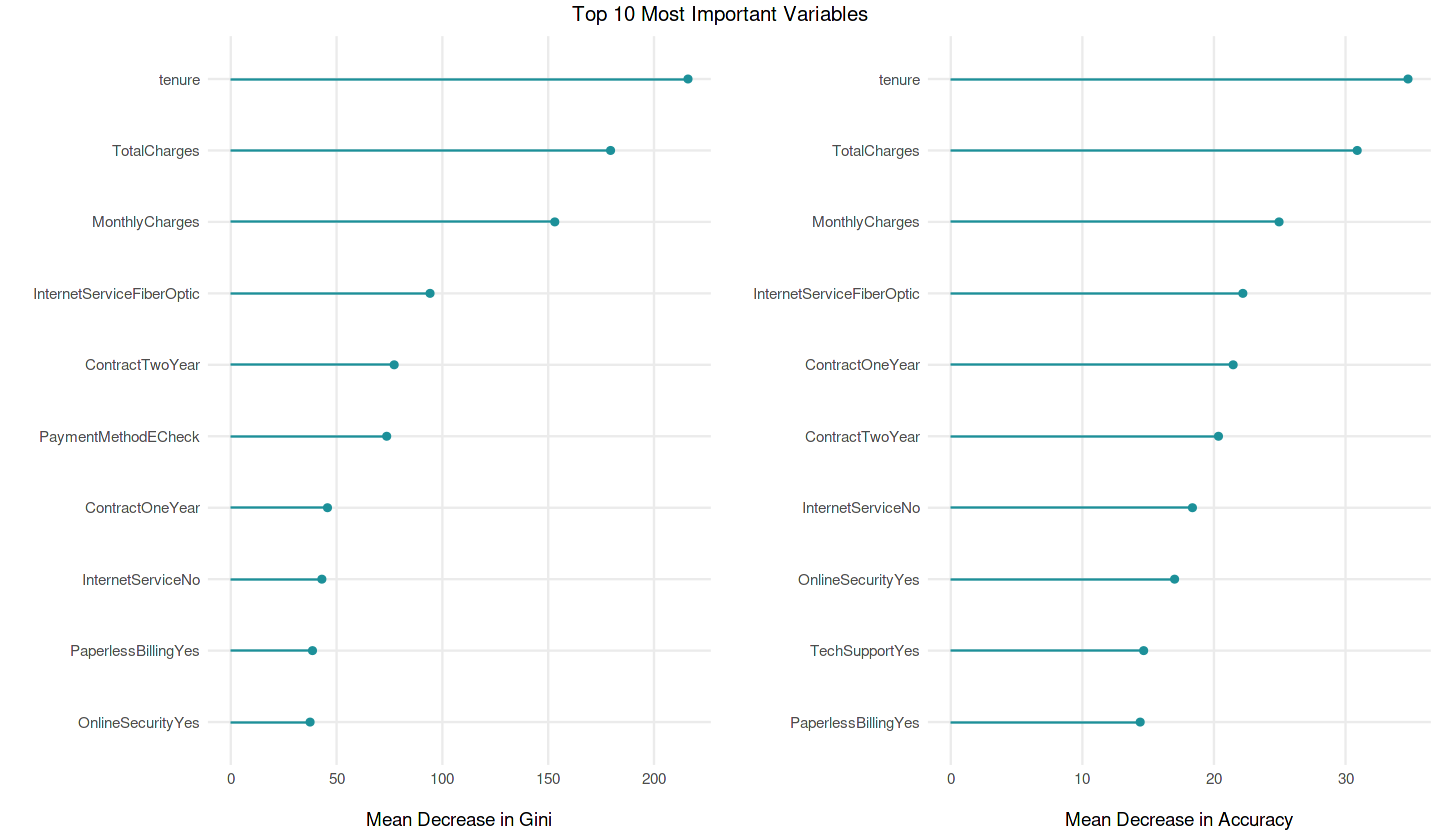

In [8]:
set.seed(1)
rf.features <- train(Churn ~ ., data = telco, method = "rf", importance = TRUE,
                     preProcess = c("center","scale"),
                     trControl = trainControl(method = "cv"))

df <- data.frame(importance(rf.features$finalModel)) %>% 
  rownames_to_column(var = "var")

g1 <- df %>% 
  slice_max(MeanDecreaseGini, n = 10) %>% 
  ggplot(aes(x = MeanDecreaseGini, y = reorder(var, MeanDecreaseGini))) + 
  geom_point(color = "#1C9099", size = 1.5) +
  geom_segment(aes(x = 0, xend = MeanDecreaseGini, y = var, yend = var), color = "#1C9099") +
  labs(x = "\nMean Decrease in Gini", y = "") +
  theme(panel.grid.minor.x = element_blank())

g2 <- df %>% 
  slice_max(MeanDecreaseAccuracy, n = 10) %>% 
  ggplot(aes(x = MeanDecreaseAccuracy, y = reorder(var, MeanDecreaseAccuracy))) + 
  geom_point(color = "#1C9099", size = 1.5) +
  geom_segment(aes(x = 0, xend = MeanDecreaseAccuracy, y = var, yend = var), color = "#1C9099") +
  labs(x = "\nMean Decrease in Accuracy", y = "") +
  theme(panel.grid.minor.x = element_blank())

options(repr.plot.width=12, repr.plot.height=7)
grid.arrange(g1, g2, nrow = 1, top = "Top 10 Most Important Variables")

Based on the plot of the most important variables, both measures include `Tenure`, `TotalCharges`, `MonthlyCharges`, `InternetService`, `PaymentMethod`, `Contract`,  `OnlineSecurity`, `TechSupport`, and `PaperlessBilling`. Due to its collinearity with `Tenure`, all of the features except for `TotalCharges` will be used as predictors in the models.

# Methodology

To predict which customers are most likely to churn, several different types of classification models will be evaluated, including logistic regression, discriminant analysis, support vector machines, and random forests. Since the numeric predictors, `MonthlyCharges` and `Tenure`, have skewed distributions and varying scales, I will apply a preprocessing technique that normalizes the features to have a mean of 0 and a standard deviation of 1. 

To fit the models, 10-fold cross-validation will be used and the model will be tested on the out of sample dataset. This set was held out of resampling and is more representative of the true class distribution. The two evaluation metrics we will focus on are precision and recall. The [precision](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall) of a model measures the proportion of positive observations that it correctly classified as positive. [Recall](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall) measures the amount of true positives that the model identified correctly out of the total number of true positives in the dataset. 

# Logistic Regression

Logistic regression is a parametric classification technique that estimates the probability of an event occurring, for instance, whether or not a customer will leave the company. One of the advantages of the logistic model is the interpretability of the model parameters. Based on the size of the coefficients and the significance of the predictors, the model is able to quantify the relationships between our response and the input features.

In [9]:
set.seed(21)
ctrl <- trainControl(method = "cv", number = 10, classProbs = TRUE, 
                     summaryFunction = twoClassSummary)
glm.fit <- train(Churn ~ tenure + MonthlyCharges + InternetService + PaymentMethod + 
                 Contract + OnlineSecurity + TechSupport + PaperlessBilling, 
                 data = train.resamp, method = "glm", metric = "ROC",
                 preProcess = c("center", "scale"), trControl = ctrl)
glm.preds <- glm.fit %>% predict(telco.test)
glm.cm <- data.frame(Logistic=confusionMatrix(glm.preds, telco.test$Churn, 
                                              positive = "Yes", mode = "everything")$byClass)
confusionMatrix(glm.preds, telco.test$Churn, positive = "Yes", mode = "everything")

Confusion Matrix and Statistics

          Reference
Prediction   No  Yes
       No  1153  104
       Yes  395  456
                                          
               Accuracy : 0.7633          
                 95% CI : (0.7445, 0.7813)
    No Information Rate : 0.7343          
    P-Value [Acc > NIR] : 0.001281        
                                          
                  Kappa : 0.4796          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.8143          
            Specificity : 0.7448          
         Pos Pred Value : 0.5358          
         Neg Pred Value : 0.9173          
              Precision : 0.5358          
                 Recall : 0.8143          
                     F1 : 0.6464          
             Prevalence : 0.2657          
         Detection Rate : 0.2163          
   Detection Prevalence : 0.4037          
      Balanced Accuracy 

Our logistic regression model has an overall accuracy of 76.3% and a precision of 53.6% on the test set. This means that when the model predicts a customer will leave, it is correct around 54% of the time. The recall of our model is 81.4%, which means that it correctly identified about 81% of all customers who left.

## Multicollinearity Assumption

One of the assumptions of logistic regression is that the predictors are not too highly correlated with each other. The Variance Inflation Factor (VIF) measures the amount of multicollinearity between the features in the model. A general rule of thumb is a VIF score of no higher than between 5 and 10. Since the majority of the predictors have a VIF of less than 5 and none exceed 10, we are good.

In [10]:
data.frame("VIF" = VIF(glm.fit$finalModel)) %>% 
  arrange(desc(VIF))

,VIF
,<dbl>
MonthlyCharges,7.436812
InternetServiceFiberOptic,4.378157
InternetServiceNo,2.237786
tenure,2.118589
PaymentMethodECheck,2.079310
PaymentMethodMailedCheck,2.022653
PaymentMethodCreditCardAuto,1.632342
ContractTwoYear,1.429891
ContractOneYear,1.406533


# Quadratic Discriminant Analysis

The next model I will try using is Quadratic Discriminant Analysis (QDA), which is a compromise between logistic regression and nonparametric methods. The QDA model allows for quadratic decision boundaries and can produce better results when the data is moderately non-linear.

In [11]:
qda.fit <- train(Churn ~ tenure + MonthlyCharges + InternetService + PaymentMethod + 
                 Contract + OnlineSecurity + TechSupport + PaperlessBilling, 
                 data = train.resamp, method = "qda", metric = "ROC",
                 preProcess = c("center","scale"), trControl = ctrl)
qda.preds <- qda.fit %>% predict(telco.test)
qda.cm <- data.frame(QDA=confusionMatrix(qda.preds, telco.test$Churn, 
                                         positive = "Yes", mode = "everything")$byClass)
confusionMatrix(qda.preds, telco.test$Churn, positive = "Yes", mode = "everything")

Confusion Matrix and Statistics

          Reference
Prediction   No  Yes
       No  1083   94
       Yes  465  466
                                          
               Accuracy : 0.7348          
                 95% CI : (0.7154, 0.7536)
    No Information Rate : 0.7343          
    P-Value [Acc > NIR] : 0.4917          
                                          
                  Kappa : 0.439           
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.8321          
            Specificity : 0.6996          
         Pos Pred Value : 0.5005          
         Neg Pred Value : 0.9201          
              Precision : 0.5005          
                 Recall : 0.8321          
                     F1 : 0.6251          
             Prevalence : 0.2657          
         Detection Rate : 0.2211          
   Detection Prevalence : 0.4417          
      Balanced Accuracy 

The QDA model improved the recall to 83%, although the overall accuracy and precision decreased to 73% and 50% respectively.

# Support Vector Machine

Support vector machines (SVMs) are a commonly used statistical learning model. It is nonparametric, which means that it does not make any assumptions about the data like logistic regression does. SVMs involve finding a hyperplane that separates the data as well as possible and maximizes the distance between the classes of our response variable.

In [12]:
svm.fit <- train(Churn ~ tenure + MonthlyCharges + InternetService + PaymentMethod + 
                 Contract + OnlineSecurity + TechSupport + PaperlessBilling, 
                 data = train.resamp, method = "svmLinear", metric = "ROC",
                 preProcess = c("center","scale"), trControl = ctrl)
svm.preds <- svm.fit %>% predict(telco.test)
svm.cm <- data.frame(SVM=confusionMatrix(svm.preds, telco.test$Churn, 
                                         positive = "Yes", mode = "everything")$byClass)
confusionMatrix(svm.preds, telco.test$Churn, positive = "Yes", mode = "everything")

Confusion Matrix and Statistics

          Reference
Prediction  No Yes
       No  999  84
       Yes 549 476
                                          
               Accuracy : 0.6997          
                 95% CI : (0.6796, 0.7192)
    No Information Rate : 0.7343          
    P-Value [Acc > NIR] : 0.9998          
                                          
                  Kappa : 0.3916          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.8500          
            Specificity : 0.6453          
         Pos Pred Value : 0.4644          
         Neg Pred Value : 0.9224          
              Precision : 0.4644          
                 Recall : 0.8500          
                     F1 : 0.6006          
             Prevalence : 0.2657          
         Detection Rate : 0.2258          
   Detection Prevalence : 0.4862          
      Balanced Accuracy : 0.74

The accuracy of the linear support vector machine is about 70% and the precision is 46%, which is not an improvement from the previous two models. The recall did increase to 85%, which is the highest so far.

# Random Forest

Random forests is a commonly used ensemble technique in machine learning. The model is built using a combination of many decision trees, where each takes a random sample of the data with replacement and selects a random subset of predictors, resulting in a relatively uncorrelated set of decision trees. Each tree then makes a prediction and the class with the most votes becomes the model's final prediction.

In [13]:
rf.fit <- train(Churn ~ tenure + MonthlyCharges + InternetService + PaymentMethod + 
                Contract + OnlineSecurity + TechSupport + PaperlessBilling,
                data = train.resamp, method = "rf", metric = "ROC",
                preProcess = c("center","scale"), trControl = ctrl)
rf.preds <- rf.fit %>% 
  predict(telco.test)
rf.cm <- data.frame(rf=confusionMatrix(rf.preds, telco.test$Churn, 
                                       positive = "Yes", mode = "everything")$byClass)
confusionMatrix(rf.preds, telco.test$Churn, positive = "Yes", mode = "everything")

Confusion Matrix and Statistics

          Reference
Prediction   No  Yes
       No  1152  119
       Yes  396  441
                                          
               Accuracy : 0.7557          
                 95% CI : (0.7368, 0.7739)
    No Information Rate : 0.7343          
    P-Value [Acc > NIR] : 0.01356         
                                          
                  Kappa : 0.4592          
                                          
 Mcnemar's Test P-Value : < 2e-16         
                                          
            Sensitivity : 0.7875          
            Specificity : 0.7442          
         Pos Pred Value : 0.5269          
         Neg Pred Value : 0.9064          
              Precision : 0.5269          
                 Recall : 0.7875          
                     F1 : 0.6314          
             Prevalence : 0.2657          
         Detection Rate : 0.2092          
   Detection Prevalence : 0.3971          
      Balanced Accuracy 

The random forest classifier has an accuracy of 76% and a precision of 53%, higher than the QDA and SVM but just below our logistic model. The recall of the model is about 79%, the lowest overall.

# Model Evaluation 

In [14]:
res.cm <- data.frame(glm.cm, qda.cm, svm.cm, rf.cm) %>% 
  rename("Random Forest" = rf) 
res <- data.frame(t(res.cm))
rownames(res) <- colnames(res.cm)
colnames(res) <- rownames(res.cm)
res[,c(7,5,6,2,11)] %>% 
  arrange(desc(F1)) %>% 
  mutate_all(percent_format(accuracy = 0.1)) 

,F1,Precision,Recall,Specificity,Balanced Accuracy
,<chr>,<chr>,<chr>,<chr>,<chr>
Logistic,64.6%,53.6%,81.4%,74.5%,78.0%
Random Forest,63.1%,52.7%,78.8%,74.4%,76.6%
QDA,62.5%,50.1%,83.2%,70.0%,76.6%
SVM,60.1%,46.4%,85.0%,64.5%,74.8%


Out of the four models, the logistic regression model produces the highest [F1 score](https://en.wikipedia.org/wiki/F-score), which represents the balance between precision and recall, as well as the highest specificity, which measures how well the classifier identifies negative cases correctly. 

# ROC Curves

As a final step in model selection, I will plot the ROC curves of each model with their corresponding Area Under the Curve [(AUC)](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc). The Area Under the Curve measures the model's performance across all possible classification thresholds. A higher AUC indicates the model is better able to distinguish between the classes. 

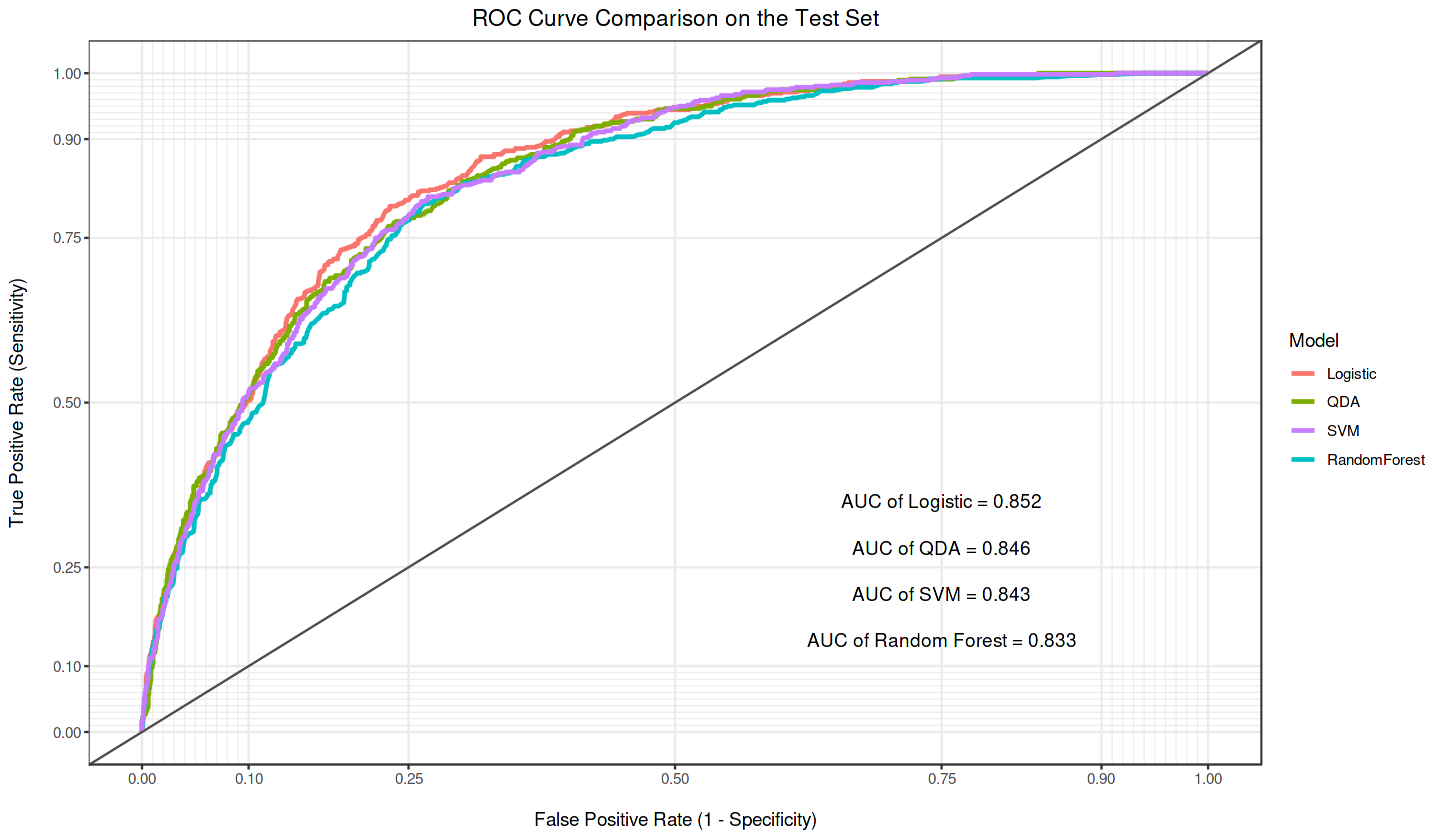

In [15]:
Logistic <- predict(glm.fit, telco.test, type = "prob")[,2]
QDA <- predict(qda.fit, telco.test, type = "prob")[,2]
SVM <- predict(svm.fit, telco.test, type = "prob")[,2]
RandomForest <- predict(rf.fit, telco.test, type = "prob")[,2]

roc.data <- cbind(telco.test[,20], Logistic, QDA, SVM, RandomForest)
roc.long <- melt_roc(roc.data, d = "Churn", m = c("Logistic", "QDA", "SVM", "RandomForest"))

rocplot <- ggplot(roc.long, aes(d = ifelse(D == "Yes", 1, 0), m = M, color = name)) +
  geom_roc(n.cuts = 0) + 
  style_roc(xlab = "\nFalse Positive Rate (1 - Specificity)", 
            ylab = "True Positive Rate (Sensitivity)\n") +
  labs(title = "ROC Curve Comparison on the Test Set", color = "Model") +
  theme(plot.title = element_text(hjust = 0.5))

rocplot +
  geom_abline(size = 0.5, color = "grey30") +
  annotate("text",x=.75,y=.35,label=paste("AUC of Logistic =", round(calc_auc(rocplot)$AUC[1],3))) +
  annotate("text",x=.75,y=.28,label=paste("AUC of QDA =", round(calc_auc(rocplot)$AUC[2],3))) +
  annotate("text",x=.75,y=.21,label=paste("AUC of SVM =", round(calc_auc(rocplot)$AUC[4],3))) +
  annotate("text",x=.75,y=.14,label=paste("AUC of Random Forest =", round(calc_auc(rocplot)$AUC[3],3))) +
  scale_color_discrete(breaks = c("Logistic", "QDA", "SVM", "RandomForest"))

Out of the four classifiers, the logistic model has the highest Area Under the Curve of 0.854 on the test set. This represents the probability that our model will rate or rank a randomly chosen observation from the positive class, `Churn = Yes`, as more likely to be from that class than a randomly chosen nonpositive observation, `Churn = No` [(Hanley & McNeil, 1982)](https://pubs.rsna.org/doi/pdf/10.1148/radiology.143.1.7063747).

# Key Findings

Overall, the logistic regression model had the strongest performance on the test set. Based on the coefficients from the model, at least one category in all eight predictors has a significant association to customer attrition. A summary of the relationships of each, when all other variables are held constant, is listed in the table below.

In [16]:
glm.fit <- train(Churn ~ tenure + MonthlyCharges + InternetService + PaymentMethod + 
                 Contract + OnlineSecurity + TechSupport + PaperlessBilling, 
                 data = telco, method = "glm", 
                 preProcess = c("center", "scale"), 
                 trControl = trainControl(method = "cv", number = 10))
summary(glm.fit$finalModel)


Call:
NULL

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7431  -0.6806  -0.2999   0.7478   3.1037  

Coefficients:
                            Estimate Std. Error z value Pr(>|z|)    
(Intercept)                 -1.61343    0.04656 -34.656  < 2e-16 ***
tenure                      -0.76083    0.05258 -14.470  < 2e-16 ***
MonthlyCharges               0.32805    0.09860   3.327 0.000878 ***
InternetServiceFiberOptic    0.26989    0.06954   3.881 0.000104 ***
InternetServiceNo           -0.32844    0.06323  -5.195 2.05e-07 ***
PaymentMethodCreditCardAuto -0.03354    0.04659  -0.720 0.471601    
PaymentMethodECheck          0.17718    0.04417   4.011 6.04e-05 ***
PaymentMethodMailedCheck    -0.01368    0.04728  -0.289 0.772271    
ContractOneYear             -0.28241    0.04279  -6.600 4.13e-11 ***
ContractTwoYear             -0.58727    0.07400  -7.936 2.09e-15 ***
OnlineSecurityYes           -0.21173    0.03854  -5.494 3.93e-08 ***
TechSupportYes              -0.

In [17]:
OR <- coef(glm.fit$finalModel) %>% exp() %>% round(digits = 2) %>% as.data.frame() %>% slice(-c(1,6,8))
data.frame(Predictor = c("Tenure", "MonthlyCharges", "InternetServiceFiberOptic", 
                         "InternetServiceNo", "PaymentMethodECheck", "ContractOneYear", "ContractTwoYear",
                         "OnlineSecurityYes", "TechSupportYes", "PaperlessBillingYes"),
           OddsRatio = OR[,1],
           Interpretation = c("A one month increase in tenure decreases the risk of churning by about 53%.",
                              "For every $1 increase in monthly charges, we expect to see an increase in 
                              the odds of churning by a factor of 1.39 or by 39%.",
                              "Customers with fiber optic internet are 31% more likely to churn than those 
                              with DSL.", "Those without internet are 28% less likely to churn than 
                              customers with DSL internet.", "Customers who pay with electronic checks are 
                              more likely to churn by a factor of 1.19 or by 19% compared to customers who use 
                              automatic bank transfers.", "Customers on one-year contracts are 25% less likely 
                              to churn than customers on month-to-month contracts.", "Customers 
                              on two-year contracts are 44% less likely to churn compared to those on 
                              month-to-month contracts.", "Customers with online security are 19% less likely 
                              to churn than customers without online security.", "Customers with tech support 
                              are about 17% less likely to churn than customers without tech support.", 
                              "Customers with paperless billing are 21% more likely to churn than customers 
                              without paperless billing.")) %>% 
  arrange(desc(OddsRatio)) 

Predictor,OddsRatio,Interpretation
<chr>,<dbl>,<chr>
MonthlyCharges,1.39,"For every $1 increase in monthly charges, we expect to see an increase in the odds of churning by a factor of 1.39 or by 39%."
InternetServiceFiberOptic,1.31,Customers with fiber optic internet are 31% more likely to churn than those with DSL.
PaperlessBillingYes,1.21,Customers with paperless billing are 21% more likely to churn than customers without paperless billing.
PaymentMethodECheck,1.19,Customers who pay with electronic checks are more likely to churn by a factor of 1.19 or by 19% compared to customers who use automatic bank transfers.
TechSupportYes,0.83,Customers with tech support are about 17% less likely to churn than customers without tech support.
OnlineSecurityYes,0.81,Customers with online security are 19% less likely to churn than customers without online security.
ContractOneYear,0.75,Customers on one-year contracts are 25% less likely to churn than customers on month-to-month contracts.
InternetServiceNo,0.72,Those without internet are 28% less likely to churn than customers with DSL internet.
ContractTwoYear,0.56,Customers on two-year contracts are 44% less likely to churn compared to those on month-to-month contracts.


# Conclusion

In predicting customer attrition, logistic regression produced the highest Area Under the Curve, F1 score, and specificity. Some of the most important predictors of customer attrition include `Tenure`, `MonthlyCharges`, `InternetService`, `PaymentMethod`, `Contract`, `OnlineSecurity`, `TechSupport`, and `PaperlessBilling`. We also found that the most significant relationships from our logistic model are the customer’s monthly charges, the type of internet service and contract they have, and the length of time they have been customers with Telco. To proactively reduce their churn rate, Telco could target customers who are on month-to-month contracts, use fiber optic internet, have higher monthly charges on average, and who have a shorter tenure of less than 18 months, which is the average tenure of their former customers.


<div class="tocify-extend-page" data-unique="tocify-extend-page" style="height: 0;"></div>

<base target="_top"/>